# Introducción a procesamiento de imágenes

Algunas librerías para procesar imágenes: numpy, pandas, cv2, skimage, PIL, matplotlib

- **Numpy** Para manipulación de matrices, utilizada para álgebra lineal, transformada de Fourier y capacidades de números aleatorios.
- **Pandas** Para manipulación y análisis de datos.
- **CV2** Para tareas de visión por computadora.
- **Skimage** Para aplicaciones de procesamiento de imágenes en Python.
- **Matplotlib** Para generar figuras y proporciona un conjunto de herramientas de interfaz gráfica de usuario.

In [16]:
import numpy as np
import pandas as pd
import cv2 as cv 
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt



Image shape: (571, 800, 3)
Image shape: (571, 800, 3)


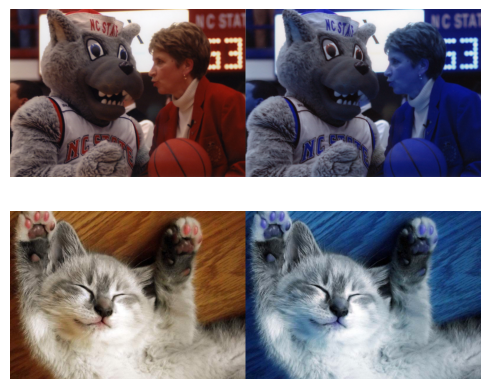

In [17]:
# Create a list to store the urls of the images
urls = ["https://iiif.lib.ncsu.edu/iiif/0016007/full/800,/0/default.jpg",
      "https://placekitten.com/800/571"]  
# Read and display the image
# loop over the image URLs, you could store several image urls in the list

fig, ax = plt.subplots(2,1)
for i,url in enumerate(urls):
  image = io.imread(url) 
  print(f'Image shape: {image.shape}')
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  final_frame = cv.hconcat((image, image_2))
  ax[i].imshow(final_frame)
  ax[i].axis('off')

In [18]:
### Download the data, if not already on disk #################################
import os
if not os.path.exists('MRbrain.tar.gz'):
    # Download the data
    try:
        from urllib import urlopen
    except ImportError:
        from urllib.request import urlopen
    print("Downloading data, Please Wait (7.8MB)")
    opener = urlopen(
                'http://graphics.stanford.edu/data/voldata/MRbrain.tar.gz')
    open('MRbrain.tar.gz', 'wb').write(opener.read())

# Extract the data
import tarfile
tar_file = tarfile.open('MRbrain.tar.gz')
try:
    os.mkdir('mri_data')
except:
    pass
tar_file.extractall('mri_data')
tar_file.close()


### Read the data in a numpy 3D array #########################################
import numpy as np
data = np.array([np.fromfile(os.path.join('mri_data', 'MRbrain.%i' % i),
                                        dtype='>u2') for i in range(1, 110)])
data.shape = (109, 256, 256)
data = data.T
print(data.shape)
ratio = (0.5,0.5,1)

(256, 256, 109)


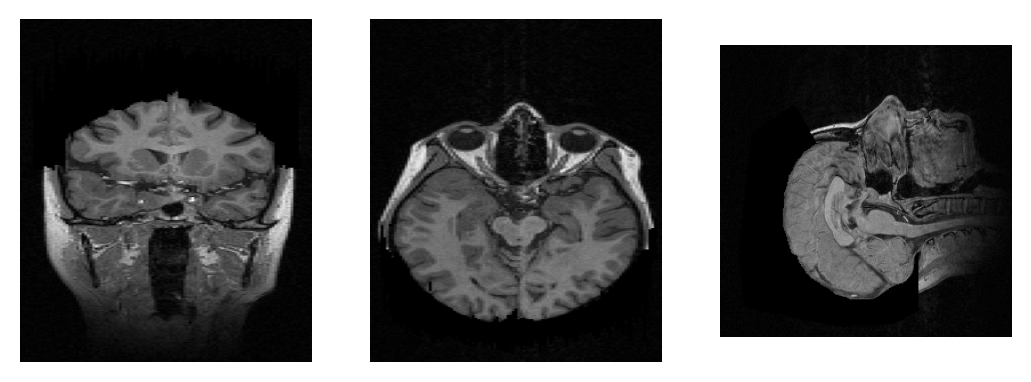

In [19]:

fig,ax =  plt.subplots(1,3)

ax[0].imshow(np.squeeze(data[128,:,:]),cmap='gray',aspect=ratio[0])
ax[1].imshow(np.squeeze(data[:,128,:]),cmap='gray',aspect=ratio[1])
ax[2].imshow(np.squeeze(data[:,:,56]),cmap='gray',aspect=ratio[2])
ax[0].axis('off');ax[1].axis('off');ax[2].axis('off');

plt.gcf().set_dpi(200)

## Histograma de una imagen

In [20]:
def NormalizeAndCast(image,dtype='uint8'):
    if dtype == 'uint8':
        return (((image - image.min()) * (1/(image.max() - image.min()))) * 255).astype(dtype)
    elif dtype == 'float32' or dtype == 'float64':
        return (((image - image.min()) * (1/(image.max() - image.min() + np.finfo(image.dtype).eps)))).astype(dtype)
    else:
        raise TypeError("Only 'float32' , 'float32' and 'uint8' dtypes are allowed")

Max: 3678, Min: 1026, Mean: 1376.8458404541016
Max: 255, Min: 0, Mean: 33.29341125488281


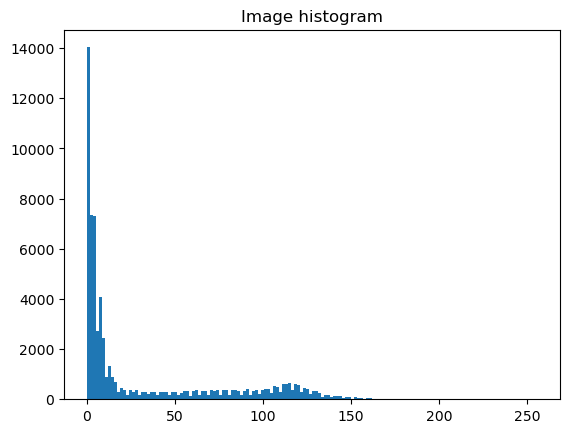

In [21]:
# Select slice
head_image = data[:,:,56]
print(f"Max: {head_image.max()}, Min: {head_image.min()}, Mean: {head_image.mean()}")
# Normalize image and cast to uint8
head_image =  NormalizeAndCast(head_image,dtype='uint8')
print(f"Max: {head_image.max()}, Min: {head_image.min()}, Mean: {head_image.mean()}")

plt.hist(head_image.ravel(),bins = 150, range = [0,256])
plt.title('Image histogram')
plt.show()

## Transformaciones y equalización de histograma

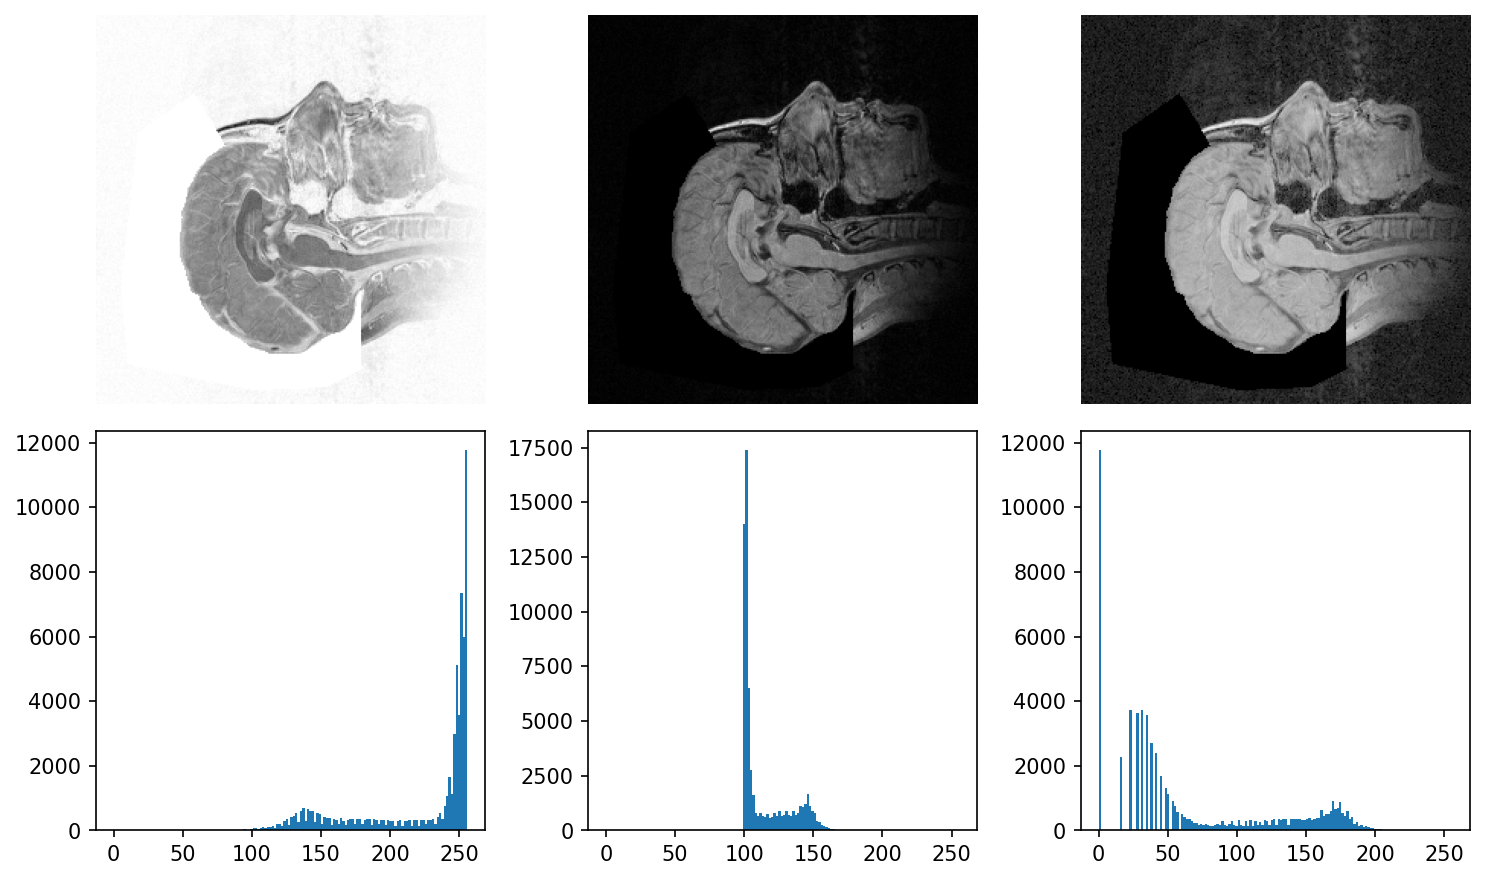

In [30]:
fig,ax = plt.subplots(2,3,figsize=(10,6))

im1 = 255 - head_image
im2 = (100.0/255)*head_image + 100
im3 = 255.0*(head_image/255.0)**(1/2)
ax.flat[0].imshow(im1,cmap='gray');ax.flat[3].hist(im1.ravel(),bins = 150, range = [0,256]);
ax.flat[1].imshow(im2,cmap='gray');ax.flat[4].hist(im2.ravel(),bins = 150, range = [0,256]);
ax.flat[2].imshow(im3,cmap='gray');ax.flat[5].hist(im3.ravel(),bins = 150, range = [0,256]);
ax.flat[0].axis('off');ax.flat[1].axis('off');ax.flat[2].axis('off');

plt.gcf().set_dpi(150)
plt.tight_layout()

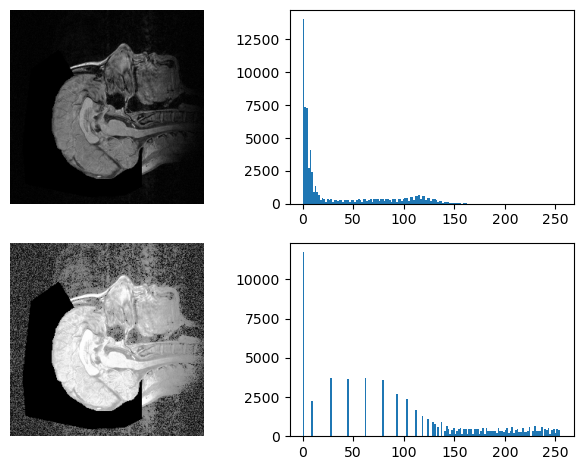

In [37]:
# function of histogram equalization
# This transform flattens the gray-level histogram so that all intensities are as equally common as possible
def histeq(im, nbr_bins = 256):
  """ Histogram equalization of a grayscale image.  """
  # get the image histogram
  imhist, bins = np.histogram(im.flatten(), nbr_bins, [0, 256])
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = imhist.max()*cdf/cdf.max()  #normalize
  cdf_mask = np.ma.masked_equal(cdf, 0)
  cdf_mask = (cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min())
  cdf = np.ma.filled(cdf_mask,0).astype('uint8')
  return cdf[im.astype('uint8')]

# apply the function on your dark image to increase the contrast
# we could observe that the contrast of the black background has increased
im4 = histeq(head_image)

fig,ax = plt.subplots(2,2)
ax.flat[0].imshow(head_image,cmap='gray');ax.flat[1].hist(head_image.ravel(),bins = 150, range = [0,256]);
ax.flat[0].axis('off');
ax.flat[2].imshow(im4,cmap='gray');ax.flat[3].hist(im4.ravel(),bins = 150, range = [0,256]);
ax.flat[2].axis('off');

plt.gcf().set_dpi(100)
plt.tight_layout()

## Convoluciones en 2D

## Transformada de Fourier 2D

### Relación convolución 2D y respuesta al impulso

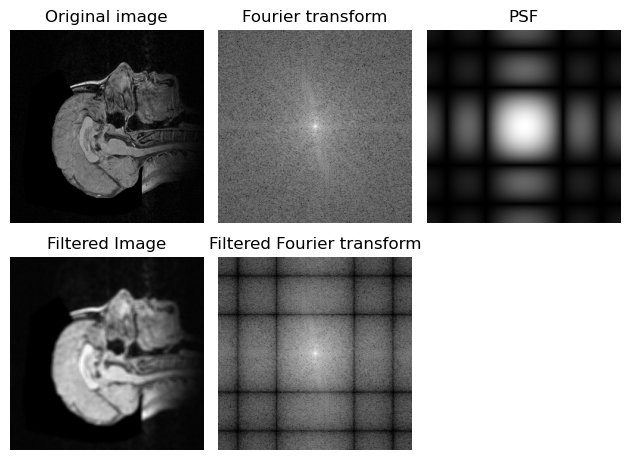

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack, signal
from skimage import io, color, transform

x = head_image

# Plot the original image
plt.subplot(231)
plt.imshow(x, cmap='gray')
plt.title("Original image")
plt.axis('off')

# Convert image to double
f = x.astype(float)

# Compute the FFT of the image
ff = np.abs(np.fft.fft2(f))

# Plot the FFT
plt.subplot(232)
plt.imshow(np.fft.fftshift(np.log(ff + 1)), cmap='gray')
plt.title("Fourier transform")
plt.axis('off')

# Define the filter
h = np.ones((5, 5)) / 9

# Compute the frequency response of the filter
hf = np.abs(np.fft.fftshift(np.fft.fft2(h, s=f.shape)))

# Plot the filter's frequency response
plt.subplot(233)
plt.imshow(np.log(hf + 1), cmap='gray')
plt.title("PSF")
plt.axis('off')

# Convolve the image with the filter
y = signal.convolve2d(f, h, mode='same', boundary='wrap')

# Plot the convolved image
plt.subplot(234)
plt.imshow(y, cmap='gray')
plt.title("Filtered Image")
plt.axis('off')

# Compute the FFT of the convolved image
yf = np.abs(fftpack.fft2(y))

# Plot the FFT of the convolved image
plt.subplot(235)
plt.imshow(np.fft.fftshift(np.log(yf + 1)), cmap='gray')
plt.title("Filtered Fourier transform")
plt.axis('off')

plt.tight_layout()
plt.show()
